# 1. Model diagnostics

@Guus: tekst nog aanpassen.

In dit notebook zijn diverse diagnostische testen en controles op de resultaten van de zeespiegelmonitor geïmplementeerd.

De volgende statistische toetsen en controles zijn hieronder uitgewerkt.
-	Toets op normaliteit: Jarque-Bera test en Q-Q plot van residuen (quantile-quantile plot, ook wel normal probability plot genoemd).
-	Controle op uitbijters (outlier detection): standaard residuenplot en een plot van de residuen tegen de leverage (een functie van de regressoren) en grafieken van de predictie-intervallen van het regressiemodel en de waarnemingen liggen.
-	Toets op seriecorrelatie: Breusch-Godfrey test (2).
-	Toets op autocorrelatie: Durbin-Watson test (2).
-	Toets op homo-/heteroskedasticiteit (is de variantie van de residuen gelijk over de gehele sample):  Breusch-Pagan test, NCV test, plot residuals vs. fitted values en plot sqrt(standardized residuals) vs. fitted values. (1) en (3) 

(1) In R levert plot(LinMod) vier grafieken op. Linksboven staat de plot residuals vs. fitted values, linksonder de plot sqrt(standardized residuals) vs. fitted values. Rechtsboven staat de Q-Q plot van de residuen. Rechtsonder staat een plot van residuals vs. leverage, waarbij leverage een functie is van de regressoren. Zie ook https://data.library.virginia.edu/diagnostic-plots/. 

(2) De toetsen op seriecorrelatie en autocorrelatie hebben veel met elkaar te maken. Zie http://www.eviews.com/help/helpintro.html#page/content/timeser-Testing_for_Serial_Correlation.html

(3) Zie https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/ en https://www.theanalysisfactor.com/linear-models-r-diagnosing-regression-model/

N.B. Jarque-Bera en Durbin-Watson zitten al in standaard model summary.

In [45]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

import statsmodels.graphics.regressionplots as plots

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

Loading BokehJS ...

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

In [3]:
# Load notebook with basic io functionality (wind, PSMSL) and standard linear model
execute_notebook('../satellite/get-data.ipynb')

In [4]:
# laad eerste het model met de summary
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]

# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names, include_wind=False)

rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In [5]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'The sea water level data of the following stations are analyzed: {", ".join(station_names)}')

The sea water level data of the following stations are analyzed: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


In [57]:
mean_df.index = mean_df['year']
display(mean_df.head())

,year,height,surge
year,,,
1890,1890,-194.666667,-0.960549
1891,1891,-179.000000,-0.960549
1892,1892,-166.500000,-0.960549
1893,1893,-142.166667,-0.960549
1894,1894,-141.833333,-0.960549


In [58]:
# Add surge
# Load surge and convert from meters to mm
surge = pandas.read_pickle('D:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000
# Calculate average over given stations, per year
# if monthly averages are needed, groupby "surge.index.month"
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)
# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

# Create a corrected dataframe by subtracting the surge
mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']   

# mean_df_corrected = mean_df_corrected[mean_df_corrected['year'] >= 1979]

In [59]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

In [60]:
linear_fit_with_surge, names = linear_model_with_surge(mean_df)
table = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1890 - current), with surge (1979-current)'
)
display(table)

<class 'statsmodels.iolib.summary.Summary'>
"""
           Linear model (1890 - current), with surge (1979-current)           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     250.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           7.49e-58
Time:                        12:14:56   Log-Likelihood:                -587.85
No. Observations:                 127   AIC:                             1186.
Df Residuals:                     122   BIC:                             1200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.8161      2.480     -9.604      0.000     -28.725     -18.907
Trend          1.9090      0.061     31.047      0.000       1.787       2.031
Nodal U        5.2603      3.196      1.646      0.102      -1.066      11.586
Nodal V      -10.6493      3.177     -3.352      0.001     -16.939      -4.359
Surge          0.9009      0.142      6.325      0.000       0.619       1.183
==============================================================================
Omnibus:                        3.618   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.093
Skew:                          -0.295   Prob(JB):                        0.213
Kurtosis:                       3.486   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
linear_fit_with_surge_1979, names = linear_model_with_surge(mean_df[mean_df.year >= 1979])
table_1979 = linear_fit_with_surge_1979.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model (1979-current), with surge (1979-current)'
)
display(table_1979)

<class 'statsmodels.iolib.summary.Summary'>
"""
            Linear model (1979-current), with surge (1979-current)            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     64.43
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           4.00e-15
Time:                        12:14:57   Log-Likelihood:                -150.50
No. Observations:                  38   AIC:                             311.0
Df Residuals:                      33   BIC:                             319.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -34.8554      6.381     -5.462      0.000     -47.839     -21.872
Trend          2.4032      0.218     11.037      0.000       1.960       2.846
Nodal U       -4.4835      3.109     -1.442      0.159     -10.808       1.841
Nodal V      -12.1689      3.427     -3.550      0.001     -19.142      -5.196
Surge          0.9246      0.077     11.938      0.000       0.767       1.082
==============================================================================
Omnibus:                        0.618   Durbin-Watson:                   1.179
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.684
Skew:                           0.089   Prob(JB):                        0.710
Kurtosis:                       2.367   Cond. No.                         89.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

N.B. Blijkbaar kan je de covariantiematrix, de standaardfouten, ook robuust schatten.

@Durbin-Watson test
Nog checken:
- omvang dataset: 1890-2016 (T = 127), dus geen data vanaf 2017 beschikbaar via PSMSL.
- aantal parameters inclusief constante: K = 5 (df model:= K-1 = 4)
- test alleen op data vanaf 1979?

PM
The null hypothesis is that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process. The Durbin-Watson test statistic equals 1.541. The critical values at 5% significance are: (low) 1.64595, (high) 1.77568. This implies that we should reject the null hypothesis.

Fit model to data from 1979 onwards, gives an even lower DW test statistic, implying rejection of the null-hypothesis.

*In statistics, the Durbin–Watson statistic is a test statistic used to detect the presence of autocorrelation at lag 1 in the residuals (prediction errors) from a regression analysis. It is named after James Durbin and Geoffrey Watson. The small sample distribution of this ratio was derived by John von Neumann (von Neumann, 1941). Durbin and Watson (1950, 1951) applied this statistic to the residuals from least squares regressions, and developed bounds tests for the null hypothesis that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process. 


## Normality
Let us first check if the (fitted) residuals are normally distributed. We do several visual checks and consider statistical tests.

### Statistical test
The Jarque-Bera test statistic is 2.807 with p-value 0.246. Hence, the null hypothesis of normality cannot be rejected at a significance level of 5%.

### Q-Q-plot of the residuals
Next we create the quantile-quantile plot of the residuals. That is, we plot the theoretical quantiles (normal distribution) against the data quantiles (ranks).

The Q-Q-plot does not show large irregularities in the residuals. Higher quantiles (0.7-0.9) are somewhat overrepresented and the quantiles 0.3-0.5 are somewhat underrepresented. 

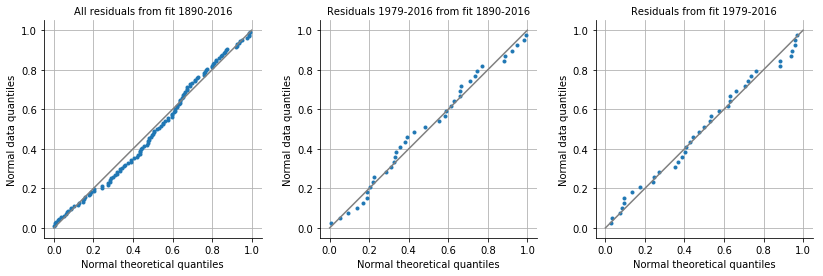

In [62]:
fig, axs = plt.subplots(figsize=(14, 4), ncols=3)
from scipy.stats import norm

for startyear, ax, fit, title in zip(
    [1890, 1979, 1979],
    axs,
    [linear_fit_with_surge, linear_fit_with_surge, linear_fit_with_surge_1979],
    ['All residuals from fit 1890-2016', 'Residuals 1979-2016 from fit 1890-2016', 'Residuals from fit 1979-2016']
):
    
    years = fit.model.exog[:, 1] + 1970
    index = (years >= startyear)
#     print(index)

    
    ax.set_aspect(1.0)

    # Calculate the exceedance probabilities given a normal distribution
    residuals = fit.resid.values[index]
    cprob = norm.cdf(
        sorted(residuals),
        loc=residuals.mean(),
        scale=residuals.std()
    )
    # Calculate the data quantiles: rank / (n + 1)
#     print(fit.resid.rank().values)
#     print(np.argsort(residuals))
    ranks = (np.arange(len(residuals)) + 1) / (len(residuals) + 1)

    # Scatter
    ax.plot(cprob, ranks, marker='.', ls='')
    # Plot the 1-1 line
    ax.plot([0, 1], [0, 1], ls='-', color='0.5')

    # Layout
    ax.grid()
    ax.set_ylabel('Normal data quantiles')
    ax.set_xlabel('Normal theoretical quantiles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(title, fontsize=10)

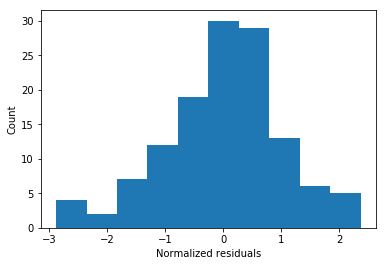

In [63]:
norm_resid = (linear_fit_with_surge.resid - linear_fit_with_surge.resid.mean()) / linear_fit_with_surge.resid.std() 

plt.hist(norm_resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals');

### Outliers
Outliers can have an impact on the parameter estimates and the fitted residuals. Below we first plot the fitted sea levels including confidence and prediction intervals. Next we plot the residuals against time and against leverage (?definition).

@Guus: kan je hier de genoemde grafieken maken, ik ben al begonnen. 
- een grafiek opnemen van het model met surge inclusief de 95%-betrouwbaarheids- en predictie-intervallen?
- standaard residuenplot maken?
- residuen tegen leverage?


In [64]:
# Code om betrouwbaarheidsintervallen en predictie-intervallen te maken

# Confidence intervals paramemeters using t-distribution
# print(linear_fit_with_surge.conf_int(alpha=0.05, cols=None)) 
## linear_fit_with_surge.conf_int_el # using empirical likelihood

from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
lfws = linear_fit_with_surge
st, data, ss2 = summary_table(lfws, alpha=0.05)
#print(lfws.model.nobs)
#print(lfws.model.exog_names)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T # confidence interval
predict_ci_low, predict_ci_upp = data[:,6:8].T # prediction interval

# check we got the right things
#print(fittedvalues)
#print(np.max(np.abs(lfws.fittedvalues - fittedvalues)))
#print(np.max(np.abs(iv_l - predict_ci_low))) #iv_l and iv_u are lower and upper values prediction interval from another method
#print(np.max(np.abs(iv_u - predict_ci_upp))) #

In [65]:
# plot the model with storm surge and add confidence and prediction intervals
# grafieken van de predictie-intervallen van het regressiemodel en de waarnemingen.
for startyear in [1890, 1979]:

    fig = bokeh.plotting.figure(x_range=(startyear, 2020), plot_width=900, plot_height=400)

    fig.circle(
        mean_df.year,
        mean_df.height,
        line_width=1,
        legend='Annual sea level (data)',
        color='black',
        alpha=0.5
    )

    fig.line(
        linear_fit_with_surge.model.exog[:, 1] + 1970, 
        linear_fit_with_surge.predict(), 
        line_width=3, 
        legend='Current sea level (linear model with surge)', 
        color='black',
        alpha=0.5
    )
    
    for values, label, color, lw in zip([predict_ci_low, predict_ci_upp, predict_mean_ci_low, predict_mean_ci_upp],
                             ['95% prediction interval', '', '95% confidence interval', ''],
                             ['blue', 'blue', 'red', 'red'],
                             [2, 2, 1, 1]):
        fig.line(
            linear_fit_with_surge.model.exog[:, 1] + 1970, 
            values, 
            line_width=lw, 
            legend=label, 
            color=color,
            alpha=0.5
        )

    
    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'water level [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    #fig.legend.click_policy = "hide"

    bokeh.io.show(fig)

In [66]:
# Controle op uitbijters (outlier detection): standaard residuenplot 

# residual plot
fig = bokeh.plotting.figure(x_range=(1979, 2020), plot_width=900, plot_height=400)
fig.circle(
    mean_df.year,
    linear_fit_with_surge.resid,
    line_width=1,
    legend='Residuals',
    color='black',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'water level [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

# De grafiek toont toch wel een (cyclisch) patroon in de residuen en (dus) een bepaalde mate van autocorrelatie.

# To do: # een plot van de residuen tegen de leverage (een functie van de regressoren) 


In [67]:
# influence = linear_fit_with_surge_1979.get_influence()
# frame = influence.summary_frame()
# display(frame.sort_values(by='hat_diag', ascending=False).head())

# print(linear_fit_with_surge.model.exog[106, 1] + 1970)
# fig, ax = plt.subplots()

# ax.scatter(frame['hat_diag'], frame['standard_resid'], s=20, alpha=0.5)
# ax.set_ylabel('Standardized residuals')
# ax.set_xlabel('Leverage');

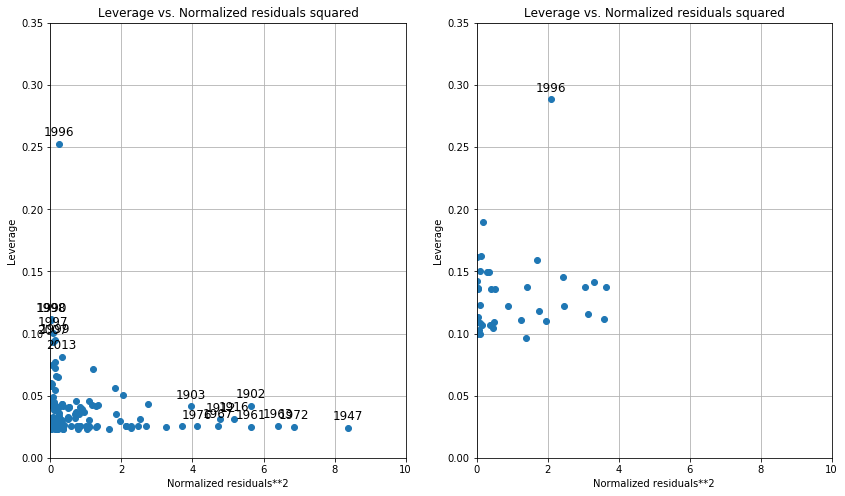

In [68]:
fig, axs = plt.subplots(figsize=(14, 8), ncols=2)
plots.plot_leverage_resid2(linear_fit_with_surge, ax=axs[0]);
plots.plot_leverage_resid2(linear_fit_with_surge_1979, ax=axs[1]);

for ax in axs:
    ax.set_ylim(0.0, 0.35)
    ax.set_xlim(0.0, 10.0)
    ax.grid()

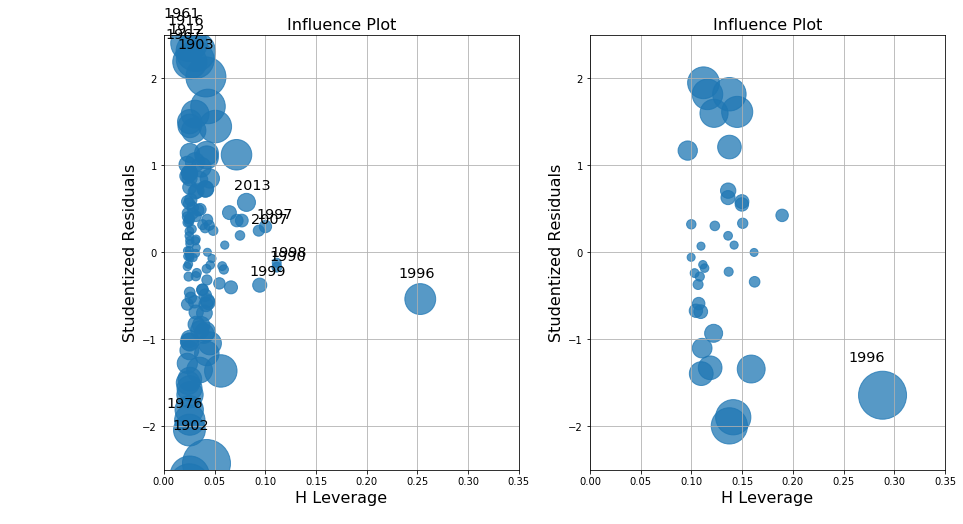

In [71]:
fig, axs = plt.subplots(figsize=(14, 8), ncols=2)
plots.influence_plot(linear_fit_with_surge, ax=axs[0]);
plots.influence_plot(linear_fit_with_surge_1979, ax=axs[1]);

for ax in axs:
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlim(0.0, 0.35)
    ax.grid()

In [ ]:
plots.influence_plot(linear_fit_with_surge);

In [43]:
frame

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
0,-0.023384,0.155605,5.318099e-02,0.117190,0.008809,1.043597e-02,-0.228521,-0.228429,0.045391,-1.047565,-1.047987
1,-0.013467,0.082839,4.395687e-03,0.067755,0.005890,3.064856e-03,-0.123453,-0.123791,0.043553,-0.580113,-0.578529
2,-0.004508,0.026641,-6.726335e-03,0.020662,0.002084,3.247531e-04,-0.040137,-0.040296,0.042115,-0.192175,-0.191415
3,0.016858,-0.099166,5.276676e-02,-0.061980,-0.007585,4.543383e-03,0.150429,0.150721,0.041178,0.727293,0.725881
4,0.016341,-0.098625,7.342666e-02,-0.037855,-0.006487,4.519772e-03,0.150039,0.150329,0.040756,0.729311,0.727904
5,-0.010594,0.067057,-5.761067e-02,0.005722,0.003188,2.090675e-03,-0.101925,-0.102242,0.040776,-0.495889,-0.494351
6,-0.018644,0.124998,-1.077807e-01,-0.028646,0.003047,7.170121e-03,-0.189215,-0.189343,0.041103,-0.914533,-0.913915
7,-0.011785,0.083291,-6.310789e-02,-0.043253,-0.000050,3.155930e-03,-0.125288,-0.125617,0.041570,-0.603167,-0.601588
8,0.021825,-0.159305,8.966162e-02,0.119849,0.003884,1.129905e-02,0.237971,0.237687,0.042025,1.134829,1.136181
9,0.021156,-0.154225,4.674837e-02,0.139747,0.006860,1.048146e-02,0.229102,0.228926,0.042351,1.088603,1.089437


### Serial correlation: Breusch-Godfrey test
Null hypothesis: no serial correlation

In [ ]:
import pandas as pd
import statsmodels

fig = bokeh.plotting.figure(x_range=(1979, 2020), y_range=(-50, 50), plot_width=900, plot_height=400)

resid_df = pd.DataFrame(
    data=linear_fit_with_surge.resid.values,
    index=mean_df_corrected.year,
    columns=['residuals']
)
resid_df['5 year rolling average'] = resid_df.rolling(window=5, center=True).mean()

fig.line(resid_df.index.values, resid_df['residuals'].values,
         line_width=2, color='blue', alpha=0.5, legend='Residuals')
fig.line(resid_df.index.values, resid_df['5 year rolling average'].values,
         line_width=2, color='red', alpha=0.5, legend='Moving average (5 years)')


fig.legend.location = "top_left"
fig.yaxis.axis_label = 'water level [mm] above NAP'
fig.xaxis.axis_label = 'year'

bokeh.io.show(fig)

# statsmodels.stats.diagnostic.acorr_breusch_godfrey?
bg = statsmodels.stats.diagnostic.acorr_breusch_godfrey(linear_fit_with_surge)

print("""
Lagrange multiplier test statistic: {:.3f}
P-value for Lagrange multiplier test: {:.3f}
Fstatistic for F test: {:.3f}
P-value for F test: {:.3f}
""".format(*bg))

The null hypothesis "No serial correlation" is rejected at the 5% significance level. This is in line with the outcome of the Durbin-Watson test.

@ We gaan sowieso geen autocorrelatie introduceren. Wel kunnen we de standaardfouten op andere, meer robuuste, wijze schatten.

### Homoscedastic or heteroskedastic residuals: Breusch-Pagan test
Null hypothesis: homoscedastic residuals

In [ ]:
residuals = linear_fit_with_surge.resid.values
#statsmodels.stats.diagnostic.het_breuschpagan?
bp = statsmodels.stats.diagnostic.het_breuschpagan(resid_df[['residuals']].values, mean_df_corrected.values)
# statsmodels.stats.diagnostic.het_breuschpagan?

print("""
Lagrange multiplier test statistic: {:.3f}
P-value for Lagrange multiplier test: {:.3f}
Fstatistic for F test: {:.3f}
P-value for F test: {:.3f}
""".format(*bp))

Null hypothesis is rejected at the 5% significance level. 

However, we consider all residuals, whereas the model includes storm surge data from 1979.  

@ Guus: alleen data van na 1979 beschouwen.